## Projekt "Kaufen oder Warten"
Die Situation kennen alle, die ab und zu Flugtickets kaufen: Sollte man besser warten, weil der Preis vielleicht noch fällt, oder sollte man kaufen? Insbesondere bei der Fluggesellschaft, um die es in diesem Projekt geht, sind scheinbar erratische Preisveränderungen bekannt. Die übliche Regel "je früher, desto besser" ist hier oft nicht die beste Empfehlung.

## Datenbeschreibung
Der Datensatz train_set.csv enthält Preisanfragen zu bestimmten Zeitpunkten für Flüge. Es werden nur zwei verschiedene Strecken in beiden Richtungen betrachtet: zwischen London Stansted und Berlin Schönefeld sowie zwischen London Stansted und Frankfurt.

Die folgenden Merkmale sind enthalten:

Request_Date: Datum und Uhrzeit der Preisanfrage
Flight_Date: Datum des Flugs
Departure_hour: Gerundete Abflugszeit
flight_unique_id: Eindeutige ID für den Flug
route_abb: Abkürzung der Flugroute
Price_In_Eur: Flugpreis
min_future_price_in_Eur: Minimaler Flugpreis für die flight_unique_id über alle zukünftigen Request_Dates
buy: 1 = kaufen, 0 = warten (vorherzusagende Klasse)
Die buy-Klasse wird wie folgt berechnet: if Price_In_Eur - min_future_price_in_Eur <= 0 then 1 else 0

## Aufgabe
Sie sollen ein Modell für eine Kaufempfehlung aus den Daten lernen. Interpretieren Sie ein Zeile in dem Datensatz als eine Preisabfrage, die Sie als Kunde durchführen. Das zu lernende Modell soll Ihnen dann empfehlen, zu dem Preis zu kaufen oder besser zu warten.

Für den ersten Teil der Arbeit überlegen Sie sich, wie Sie solch ein Modell in der Praxis gestalten und anwenden würden. Versetzen Sie sich dazu in die Lage eines Kunden und/oder in die Lage eines Unternehmens. Was könnte bei letzterem das Geschäftsmodell sein?

Welchen Einfluss haben diese Überlegungen auf das Konzept des zu lernenden Modells?

Halten Sie sich beim Vorgehen bitte an die allgemeinen Schritte, die ich oben für alle Projekte beschrieben habe.

## Modellgüte
Benutzen Sie zunächst einfache Vorhersagegenauigkeit zur Beurteilung der Modellgüte (Accuracy). Messen Sie also die Anzahl der richtigen Entscheidungen (Kaufen oder Warten) durch die Anzahl aller Entscheidungen.

Überlegen Sie dann, wie man aus Sicht eines Kunden bzw. Ihres Geschäftsmodells die Güte der Kaufempfehlungen messen sollte. Hier spielen sicher monetäre Überlegungen und Kundenzufriedenheit eine größere Rolle als nur möglichst genaue Empfehlungen. Denken Sie hierbei auch daran, dass man sich als Kunde nicht dem Stress aussetzen möchte, ständig Preise abzufragen.

Sie werden Ihre Ideen bei der Zwischenpräsentation vorstellen und diskutieren. Sie haben dann die Gelegenheit, für den zweiten Teil der Arbeit (Bauen der Modelle) Ihre Überlegungen basierend auf den Diskussionen anzupassen und auch Ideen von anderen Gruppen aufzunehmen.

## Wettbewerb
Es gibt einen Testdatensatz (s.u.), der dasselbe Datenformat wie der Trainingsdatensatz aufweist - nur die Spalten min_future_price_in_Eur und buy fehlen, da diese in der Anwendungssituation nicht bekannt wären. Für die Abgabe der Arbeit sollen Sie Ihre Modelle auf den Testdatensatz anwenden und das Ergebnis mit abgeben (Beschreibung siehe beim Abgabetermin weiter oben in Moodle). Wir werden die besten Modelle als Sieger küren, wenn alle Gruppen abgegeben haben.

Dazu werden wir zwei verschiedene Gütemaße betrachten: die einfache Genauigkeit (Accuracy) und das monetäre Gütemaß, auf das wir uns noch einigen werden.

In [56]:
import pandas as pd
pd.set_option("display.max_columns", None)
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import seaborn as sns
sns.set_theme(style="whitegrid")
from datetime import datetime
from dateutil import tz
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.linear_model import LassoCV
import lightgbm as lgb
from sklearn.metrics import accuracy_score, roc_auc_score

In [2]:
# Trainingsdaten in einer Dataframme einlesen
flug_df = pd.read_csv("https://raw.githubusercontent.com/hahaha996/Data_Mining_Projekt/main/datasets/Data_Mining_Datasets/train_set.csv")
# Die fünf ersten Objekte ausgeben
flug_df.head()

,index,Request_Date,Flight_Date,Departure_hour,flight_unique_id,route_abb,Price_In_Eur,min_future_price_in_Eur,buy
0,1,2019-06-03T11:00:00Z,2019-06-05,19,2019-06-05 FR 146,SXF-STN,208.07,259.07,1
1,2,2019-06-03T23:00:00Z,2019-06-05,19,2019-06-05 FR 146,SXF-STN,259.07,259.07,1
2,3,2019-06-04T11:00:00Z,2019-06-05,19,2019-06-05 FR 146,SXF-STN,259.07,259.07,1
3,4,2019-06-04T23:00:00Z,2019-06-05,19,2019-06-05 FR 146,SXF-STN,259.07,259.07,1
4,5,2019-06-03T11:00:00Z,2019-06-05,21,2019-06-05 FR 147,STN-SXF,143.86,251.72,1


In [3]:
# Trestdaten in einer Dataframme einlesen
flug_df_test = pd.read_csv("https://raw.githubusercontent.com/hahaha996/Data_Mining_Projekt/main/datasets/Data_Mining_Datasets/test_set.csv")
# Die fünf letzten Objekte ausgeben
print(flug_df_test.tail())

# Prüfen, ob Merkmale in Training vorhanden sind, die in Testdaten fehlen
print(f"\nFolgende Merkmale fehlen in Testdaten: {set(flug_df) - set(flug_df_test)}")


      index          Request_Date Flight_Date  Departure_hour  \
5578   5579  2019-07-30T23:00:00Z  2019-08-02              22   
5579   5580  2019-07-31T11:00:00Z  2019-08-02              22   
5580   5581  2019-07-31T23:00:00Z  2019-08-02              22   
5581   5582  2019-08-01T11:00:00Z  2019-08-02              22   
5582   5583  2019-08-01T23:00:00Z  2019-08-02              22   

        flight_unique_id route_abb  Price_In_Eur  
5578  2019-08-02 FR 8545   SXF-STN         42.83  
5579  2019-08-02 FR 8545   SXF-STN         50.99  
5580  2019-08-02 FR 8545   SXF-STN         50.99  
5581  2019-08-02 FR 8545   SXF-STN         50.99  
5582  2019-08-02 FR 8545   SXF-STN         50.99  

Folgende Merkmale fehlen in Testdaten: {'min_future_price_in_Eur', 'buy'}


# **Deskriptive Datenanalyse**

In [4]:
# Funktion zur Ausgabe von Informationen über den DataFrame einschließlich Indexdatentyps 
#Spalten und Nicht-Null-Werte

def check_data(data, data_type):
    
    print(f"---------------------------------------\nGrundaten über {data_type} Dataset\n---------------------------------------")
    print(f"Anzahl von Datenpunkten: {len(data)}")
    print(f"Anzahl von Merkmalen: {len(data.columns)}\n")
    print(f"Datentypen:\n-----------\n{data.dtypes} \n")
    print(f"Fehlende Werte:\n---------------\n{data.isnull().sum()} \n")
    print(f"Statistiken numerische Werten:\n-------------------------------\n{data.describe().transpose()}")
    print(f"\nStatistiken kategorische Werten:\n-------------------------------\n{data.describe(include='O').transpose()}")
    print(f"\nAnzahl von Duplicates in {data_type}: {len(data.loc[data.duplicated()])}\n")
   

    
check_data(flug_df,'Trainingsdaten')

check_data(flug_df_test,'Testdaten')

---------------------------------------
Grundaten über Trainingsdaten Dataset
---------------------------------------
Anzahl von Datenpunkten: 83624
Anzahl von Merkmalen: 9

Datentypen:
-----------
index                        int64
Request_Date                object
Flight_Date                 object
Departure_hour               int64
flight_unique_id            object
route_abb                   object
Price_In_Eur               float64
min_future_price_in_Eur    float64
buy                          int64
dtype: object 

Fehlende Werte:
---------------
index                      0
Request_Date               0
Flight_Date                0
Departure_hour             0
flight_unique_id           0
route_abb                  0
Price_In_Eur               0
min_future_price_in_Eur    0
buy                        0
dtype: int64 

Statistiken numerische Werten:
-------------------------------
                           count          mean           std   min       25%  \
index               

Die Trainingsdaten bestehen aus 8 Features(Spalten)  und 83624 Exemplare (Zeilen). Davon sind 4 Spalten vom Datentyp "object", was mit String gleichzusetzen ist: Request_date, Flight_date, flight_unique_id und route_abb. Die Spalten Departure_hour und buy enthalten ganze Zahlen vom Typ int64 und die Spalten Price_In_Eur und min_future_price_in_Eur gleitkomma Zahlen vom Typ float64.
Die Statistiken zeigen unterschiedliche statischen Werte von Merkmalen. Je nachdem ob der Spalte numerische Werte oder Zeichenfolge enthält wechseln die Parameter ab. Für numerische Werte werden Anzahl(count), durschnittliche Mittelwert(mean), Standardabweichung(std), Minimum(min), Maximum(max) und Percentiles(25%,50% und 75%) berechnet. Für Zeichenfolge werden hingegen Anzahl(count), Anzahl eindeutige Werte(unique), häufigste Wert(top) und wie oft dieser Wert in den Daten vorkommt(freq) berechnet.


##### Nachfolgend werden die Wertebereiche für die numerische Spalten mit Boxplots veranschaulicht 

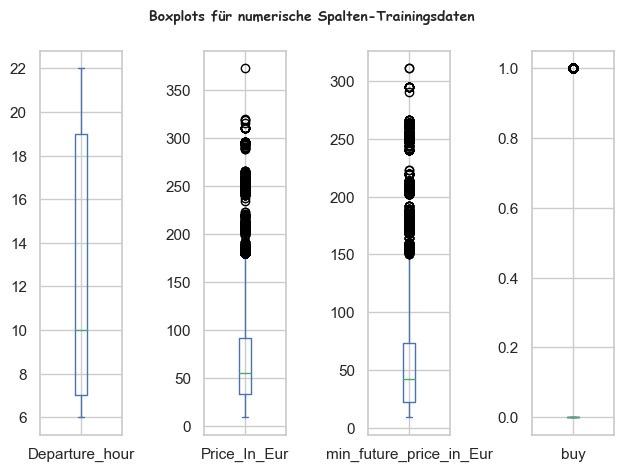

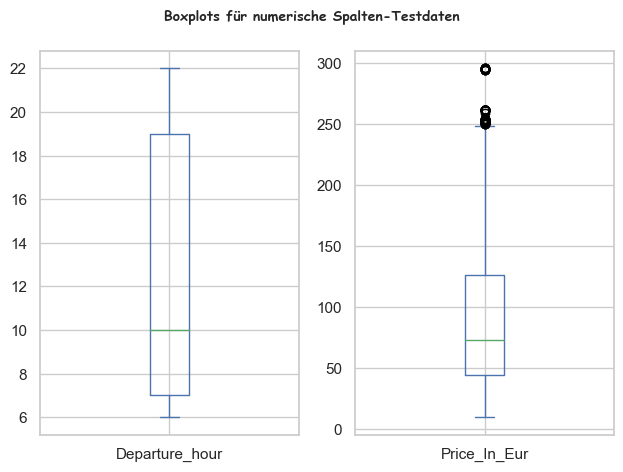

In [5]:

font = font_manager.FontProperties(family='Comic Sans MS',
                                   weight='bold',
                                   style='normal', size=10)
def Num_Spalten_visuals(dataframe, datentyp):
    
    cols = dataframe.columns
    new_col = []
    for col in cols:
        if (dataframe[col].dtypes == 'int64' or dataframe[col].dtypes == 'float64') and (col != 'index'):
            new_col.append(col)
    dataframe[new_col].plot(subplots=True,kind='box')
    plt.suptitle('Boxplots für numerische Spalten'+ datentyp,fontproperties=font)
    plt.tight_layout()
    plt.show()    

Num_Spalten_visuals(flug_df,'-Trainingsdaten')
Num_Spalten_visuals(flug_df_test,'-Testdaten')



Aus dem obigen Diagramm können wir ableiten, dass dieSpalten "Price_in_Eur" und "min_future_price_in_Eur" Ausreißer enthalten. Die Ausreißer liegen in Trainingsdaten liegen nach dem Wert "150" für min_future_price_in_Eur und nach ca "180" für Price_In_Eur".
Die Abflüge finden von 6 Uhr bis 22 Uhr statt. Für alle Abfragen gilt: Der günstigste Flug kostet 8,99 € und der teuerste 372,96

In [6]:
# Find the 75th and 25th percentiles für Price_In_Eur
price_seventy_fifth = flug_df["Price_In_Eur"].quantile(0.75)
price_twenty_fifth = flug_df["Price_In_Eur"].quantile(0.25)

# Calculate iqr
prices_iqr = price_seventy_fifth - price_twenty_fifth

# Calculate the thresholds
upper = price_seventy_fifth + (1.5 * prices_iqr)
lower = price_twenty_fifth - (1.5 * prices_iqr)

# Subset the data without outliers
flug_df_ohne_Outliers_Price = flug_df[(flug_df["Price_In_Eur"] > lower) & (flug_df["Price_In_Eur"] < upper)]

print(flug_df_ohne_Outliers_Price["Price_In_Eur"].describe())

count    78744.000000
mean        62.318011
std         39.223014
min          8.990000
25%         30.330000
50%         52.510000
75%         85.190000
max        180.210000
Name: Price_In_Eur, dtype: float64


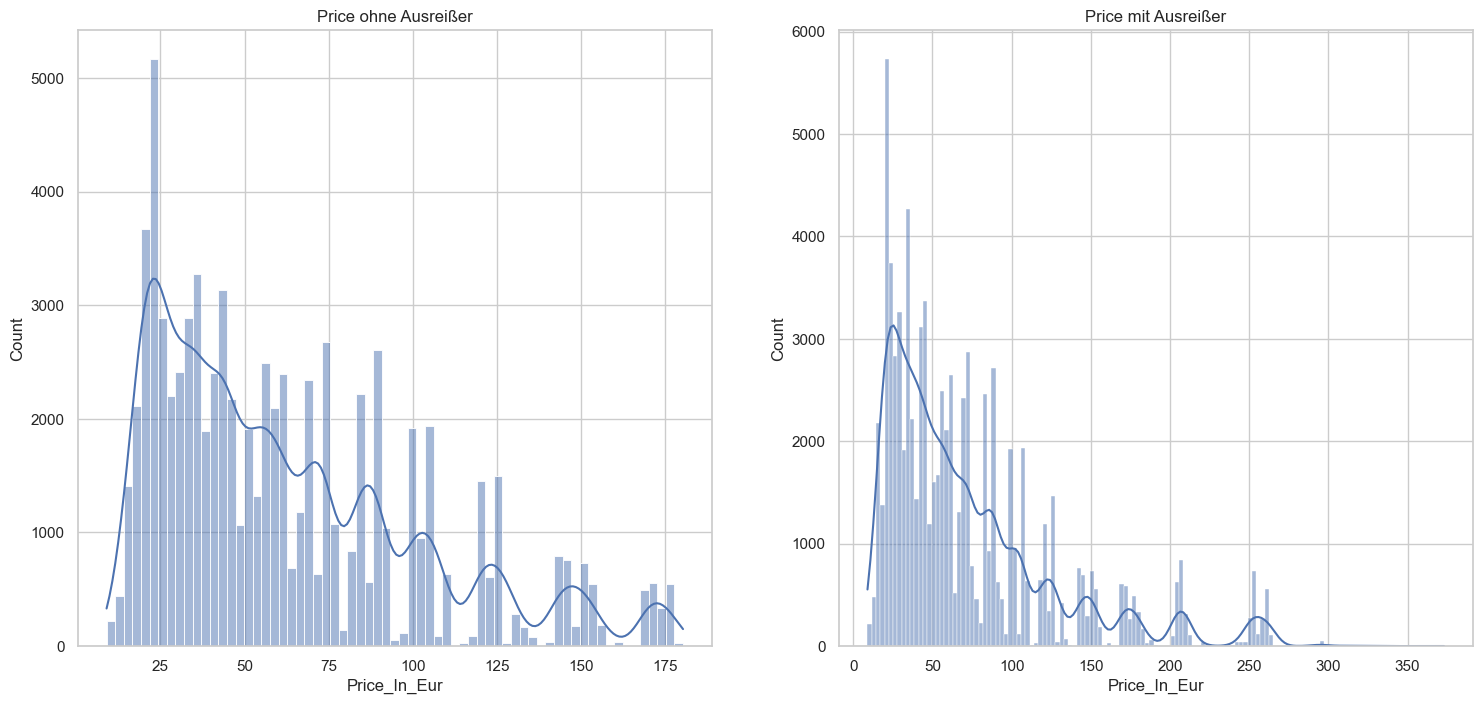

In [7]:
# Datenverteilung "Price_In_Eur" ohne Ausreißer
f,ax=plt.subplots(1,2,figsize=(18,8))
sns.histplot(data=flug_df_ohne_Outliers_Price,x='Price_In_Eur',kde='True',ax=ax[0])
ax[0].set_title('Price ohne Ausreißer')

# Datenverteilung "Price_In_Eur" mit Ausreißer
sns.histplot(data=flug_df,x='Price_In_Eur',kde='True',ax=ax[1])
ax[1].set_title('Price mit Ausreißer')
plt.show()


## Datentypkonvertierung

Wenn wir die Daten, die in den Spalten vorkommen mit ihren Datentypen vergleichen,stellt man fest, dass einige Feautures nicht der richtige Datentyp haben.Zum Beispiel 'Buy' hier ist die vorherzusagende Klasse, deswegen sollte der Feature vom Datentyp 'Category'sein. 
Die Feautures 'Request_Date'und 'Flight_Date' sollten vom Datentyp 'datetime' sein. Der Feature 'Request_Date' ist im UTC-Format gespeichert, Deswegen muss er erstmal in Localen Format umkonvertiert werden.
Der Datentyp des Features 'buy' wird später auch für das Training in den Datentyp 'category' konvertiert, da es sich hierbei um die vorherzusagende Klasse handelt.

In [8]:

def local_time(row):
    if row['route_abb'].split('-')[0] == 'SXF' or row['route_abb'].split('-')[0] == 'FRA':
        # Zeitzone
        zone = "Europe/Berlin"
    else:
        # Zeitzone
        zone = "Europe/London"
    
    # Konvertierung in ein datetime-Objekt
    dtUTC = datetime.strptime(row['Request_Date'], '%Y-%m-%dT%H:%M:%SZ')
    dtZone = dtUTC.replace(tzinfo=tz.gettz('UTC')).astimezone(tz.gettz(zone))
    
    # Formatierung des DateTime-Strings ohne Zeitzonen-Offset-Information
    dtString = dtZone.strftime('%Y-%m-%d %H:%M:%S')
    
    # Rückgabe des konvertierten Werts
    return pd.to_datetime(dtString)

# Konvertierung Trainingsdaten
flug_df['Request_Date'] = flug_df.apply( local_time, axis=1)
#flug_df['buy']= flug_df['buy'].astype('category')
flug_df['Flight_Date']= pd.to_datetime(flug_df['Flight_Date']) 

# Konvertierung Trainingsdaten
flug_df_test['Request_Date'] = flug_df_test.apply( local_time, axis=1) 
flug_df_test['Flight_Date']= pd.to_datetime(flug_df['Flight_Date'])


    
print(f"Datentyp von Features nach Konvertierung: Trainingsdaten\n\n{flug_df.dtypes}")
print(f"\nDatentyp von Features nach Konvertierung: Testdaten\n\n{flug_df_test.dtypes}")




Datentyp von Features nach Konvertierung: Trainingsdaten

index                               int64
Request_Date               datetime64[ns]
Flight_Date                datetime64[ns]
Departure_hour                      int64
flight_unique_id                   object
route_abb                          object
Price_In_Eur                      float64
min_future_price_in_Eur           float64
buy                                 int64
dtype: object

Datentyp von Features nach Konvertierung: Testdaten

index                        int64
Request_Date        datetime64[ns]
Flight_Date         datetime64[ns]
Departure_hour               int64
flight_unique_id            object
route_abb                   object
Price_In_Eur               float64
dtype: object


## Korrelationen

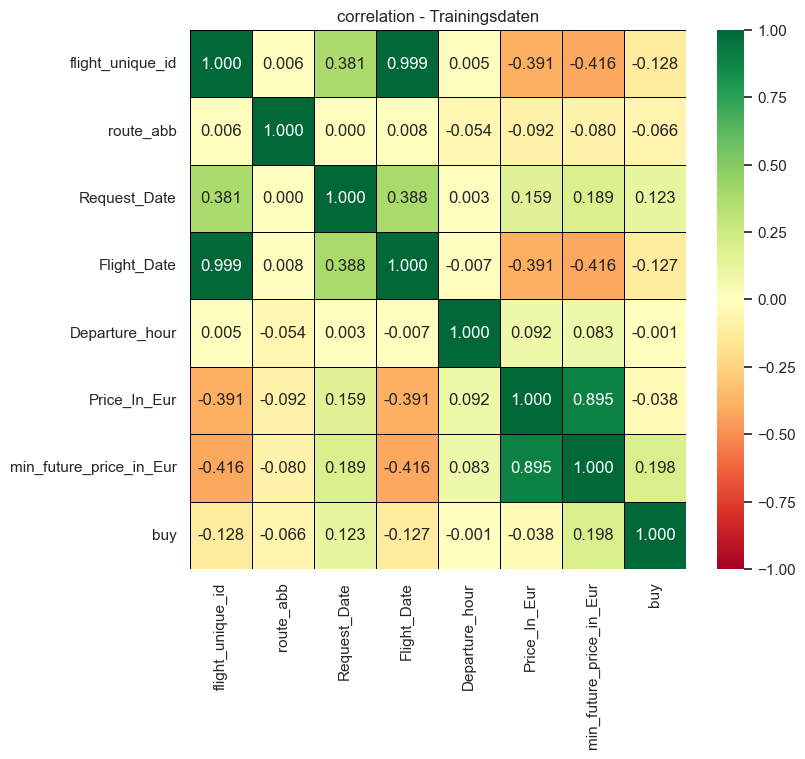

In [9]:
colcat = ['flight_unique_id', 'route_abb','Request_Date','Flight_Date']
colnum = ['Departure_hour','Price_In_Eur','min_future_price_in_Eur','buy']

#Erstellung numerischer Darstellungen von kategorialen Variablen in Trainingsdaten
df = flug_df[colcat].apply(lambda x : pd.factorize(x)[0])
df_concat = pd.concat([df,flug_df[colnum]], axis=1) 

# Berechnung der Korrelationsmatrix
corrmat=df_concat.corr(method='pearson')

# Visualisierung der Koorelationsmatrix
plt.figure(figsize=(8,7))
sns.heatmap(corrmat, annot=True,
            fmt='.3f',
            linecolor='black', linewidths=.5,
            cmap='RdYlGn', vmin=-1, vmax=+1)
plt.title('correlation - Trainingsdaten')
plt.show()

Die Korrelation zeigt, dass die beiden Merkmale 'Price_in_Eur' und 'min_future_price_in_Eur' stark korreliert sind und ein proportionalen Verhältnis aufweisen. Wenn der Wert von 'Price_in_Eur' steigt, steigt auch der Wert von 'min_future_price_in_Eur'.

## Explorative Analyse

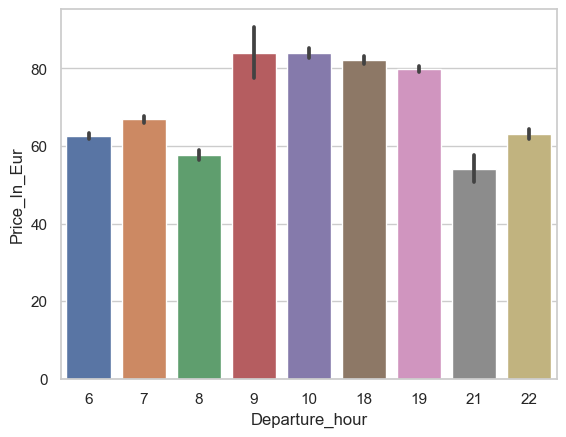

In [10]:
# hängt der Preis eines Fluges mit der Abflugzeit zusammen?
sns.barplot(data=flug_df, x='Departure_hour',y='Price_In_Eur')
plt.show()

 Flüge mit Abflug um 9 und 10 Uhr haben die höchste Preise bei Anfragen.

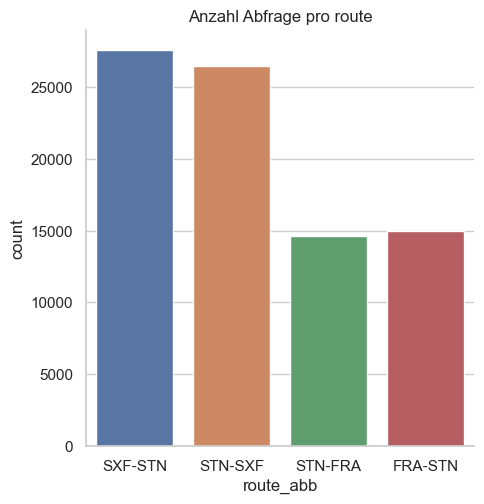

In [11]:
#welche Strecken werden am meisten abgefragt?
sns.catplot(x='route_abb', data=flug_df,kind='count')
plt.title('Anzahl Abfrage pro route')
plt.show()


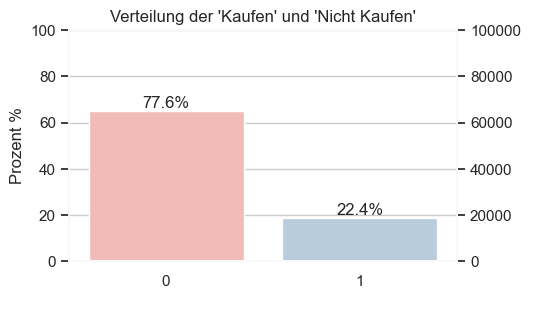

In [12]:
def default():
    ncount = len(flug_df)

    ax2=ax.twinx()

    ax2.yaxis.tick_left()
    ax.yaxis.tick_right()

    ax.yaxis.set_label_position('right')
    ax2.yaxis.set_label_position('left')

    ax2.set_ylabel('Prozent %')
    plt.title("Verteilung der 'Kaufen' und 'Nicht Kaufen'")

    for i in ax.patches:
        x=i.get_bbox().get_points()[:,0]
        y=i.get_bbox().get_points()[1,1]
        ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
                ha='center', va='bottom')

    ax2.set_ylim(0,100)
    ax2.grid(None)

ax = sns.countplot(x=flug_df.buy, palette="Pastel1")
sns.set(font_scale=1.)
ax.set_ylim(top=100000)
ax.set_xlabel(' ')
ax.set_ylabel(' ')
fig = plt.gcf()
fig.set_size_inches(5,3)
ax.set_ylim(top=100000)

default()

plt.show()


Dadurch stellt man fest das der Datensatz unbalanciert ist. Wir haben  64906 warten und nur 18718 kaufen. Was uns schon der Hinweis gibt dass, beim Aufteilen der Trainingdaten Stratifizierung verwenden sollten.

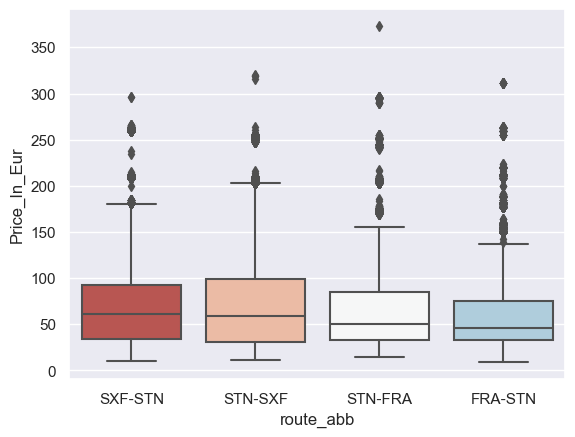

Der Mittelpreis liegt bei 74.79 wenn man der Preis von Berlin nach London abfragt
Der Mittelpreis liegt bei 77.38 wenn man der Preis von London nach Berlin  abfragt
Der Mittelpreis liegt bei 67.57 wenn man der Preis von London nach Frankfurt  abfragt
Der Mittelpreis liegt bei 61.45 wenn man der Preis von Frankfurt nach London abfragt


In [13]:
# wie teuer sind die Flüge auf die unterschiedlichen Strecken?
sns.boxplot(x = 'route_abb', y =flug_df['Price_In_Eur'], data = flug_df, palette = sns.color_palette('RdBu',5))
plt.show()
route_SXF_STN = flug_df.loc[flug_df['route_abb'] =='SXF-STN', 'Price_In_Eur']
route_STN_SXF= flug_df.loc[flug_df['route_abb'] =='STN-SXF', 'Price_In_Eur']
route_STN_FRA = flug_df.loc[flug_df['route_abb'] =='STN-FRA', 'Price_In_Eur']
route_FRA_STN = flug_df.loc[flug_df['route_abb'] =='FRA-STN', 'Price_In_Eur']
print("Der Mittelpreis liegt bei {}".format(round(route_SXF_STN.mean(), 2)), "wenn man der Preis von Berlin nach London abfragt")
print("Der Mittelpreis liegt bei {}".format(round(route_STN_SXF.mean(), 2)), "wenn man der Preis von London nach Berlin  abfragt")
print("Der Mittelpreis liegt bei {}".format(round(route_STN_FRA.mean(), 2)), "wenn man der Preis von London nach Frankfurt  abfragt")
print("Der Mittelpreis liegt bei {}".format(round(route_FRA_STN.mean(), 2)), "wenn man der Preis von Frankfurt nach London abfragt")

Das würde bedeuten es ist güngstiger in Richtung London der Flugticket von Frankfurt zu buchen und für die Rückreise nach Deutschland ist es auch günstiger in Frankfurt zu landen.

In [14]:
# Anzahl Flüge für eine Strecke an einem bestimmten Tag
f=flug_df.groupby(['Flight_Date','route_abb']).nunique()['flight_unique_id']
print(f.reset_index())
print(f'Die maximale Anzahl von Flüge an einem bestimmten Tag über eine Strecke ist {max(f.reset_index().flight_unique_id)}')


    Flight_Date route_abb  flight_unique_id
0    2019-06-05   STN-SXF                 1
1    2019-06-05   SXF-STN                 2
2    2019-06-06   STN-FRA                 1
3    2019-06-06   STN-SXF                 3
4    2019-06-06   SXF-STN                 4
..          ...       ...               ...
380  2019-09-09   STN-FRA                 2
381  2019-09-09   STN-SXF                 4
382  2019-09-09   SXF-STN                 4
383  2019-09-10   STN-SXF                 2
384  2019-09-10   SXF-STN                 2

[385 rows x 3 columns]
Die maximale Anzahl von Flüge an einem bestimmten Tag über eine Strecke ist 4


## Feature ingeneering

Basierend auf die vorhandenen Merkmalen können weitere abgeleitete Merkmale definiert werden:

- days_diff_Req_Flight: Zeitdauer bis zum Flug in Tagen (berechnet als Flight_Date - Request_Date)
- DayofWeek: Wochentag des Flugs und der Abfrage (0 bis 6)
- Month: Monat des Flugs und der Abfrage (1 bis 12)
- weekofyear: Kalenderwoche des Flugs
- Feiertage: Ein binäres Merkmal , das angibt, ob der Flug an einem Feiertag stattfindet.
- Saison: Ein Merkmal, das die Saison des Jahres (Frühling, Sommer, Herbst, Winter) basierend auf dem Flugdatum angibt.
- Departure_time und Request_time: als Umrechnung jeweils des Abflugszeit und Abfragezeit in Tageszeiten
- Source und Destination: als Zerlegung der Strecke in Start- und Endpunkt
- Price_in_eur_max,-min, und -mean: als maximaler, minimaler und mittlerer Preis für einen Flug auf eine bestimmte Strecke
- Number_of_request: als Anzahl von Abfrage je Flug



In [15]:
def generate_features(dataframe):
    #eine Reihe von Merkmalen unter Verwendung der Datumsspalten erstellen
    dataframe.loc[:,'Request_Dayofweek'] = dataframe['Request_Date'].dt.dayofweek
    dataframe.loc[:,'Request_month'] = dataframe['Request_Date'].dt.month
    dataframe.loc[:,'days_diff_Req_Flight'] = (pd.to_datetime(dataframe['Flight_Date'])- pd.to_datetime(dataframe['Request_Date'])).dt.days
    dataframe.loc[:,'Flight_Dayofweek'] = dataframe['Flight_Date'].dt.dayofweek
    dataframe.loc[:,'Flight_month'] = dataframe['Flight_Date'].dt.month
    dataframe.loc[:,'Flight_weekofyear'] = dataframe['Flight_Date'].dt.isocalendar().week
    dataframe.loc[:,'weekend']= (dataframe['Flight_Date'].dt.weekday >=5).astype(int)
    
    # Umrechnung der Departure_hour in Vormittag/Nachmittag/Abend usw.
    s = (dataframe["Departure_hour"] % 24 + 4) // 4 #give numbers from 1 to 6 #(return a series)
    # Werte ersetzen 1:latenight to 6: night
    s.replace({1: 'Late Night', 2: 'Early Morning', 3: 'Morning', 
                      4: 'Afternoon', 5: 'Evening', 6: 'Night'} ,inplace = True) 
    dataframe["departure_time"] = s
    
    # Umrechnung der Request_Time in Vormittag/Nachmittag/Abend usw.
    t = (dataframe['Request_Date'].dt.hour % 24 + 4) // 4 #give numbers from 1 to 6 #(return a series)
    # Werte ersetzen 1:latenight to 6: night
    t.replace({1: 'Late Night', 2: 'Early Morning', 3: 'Morning', 
                      4: 'Afternoon', 5: 'Evening', 6: 'Night'} ,inplace = True) 
    dataframe["Request_time"] = t
  

    #Die Merkmales source und destination aus dem Spalten route_abb erstellen
    
      
    dataframe['source'] =''
    dataframe['destination'] =''
    unique_routes = dataframe['route_abb'].unique()
    for route in unique_routes:
        if route == 'SXF-STN':
            dataframe.loc[dataframe['route_abb'] == route, 'source'] = 'Berlin'
            dataframe.loc[dataframe['route_abb'] == route, 'destination'] = 'London'
        elif route == 'STN-SXF':  # Weitere Ausprägungen hinzufügen
            dataframe.loc[dataframe['route_abb'] == route, 'source'] = 'London'
            dataframe.loc[dataframe['route_abb'] == route, 'destination'] = 'Berlin'
        elif route == 'STN-FRA':  # Weitere Ausprägungen hinzufügen
            dataframe.loc[dataframe['route_abb'] == route, 'source'] = 'London'
            dataframe.loc[dataframe['route_abb'] == route, 'destination'] = 'Frankfurt'
        elif route == 'FRA-STN':  # Weitere Ausprägungen hinzufügen
            dataframe.loc[dataframe['route_abb'] == route, 'source'] = 'Frankfurt'
            dataframe.loc[dataframe['route_abb'] == route, 'destination'] = 'London'
    return dataframe
     

            


In [16]:

def season_of_date(date):
    year = str(date.year)
    seasons = {'spring': pd.date_range(start=year+'-03-21', end=year+'-06-20'),#Frühling
               'summer': pd.date_range(start=year+'-06-21', end=year+'-09-22'),#Sommer
               'autumn': pd.date_range(start=year+'-09-23', end=year+'-12-20')}#Herbst
    if date in seasons['spring']:
        return 'spring'
    if date in seasons['summer']:
        return 'summer'
    if date in seasons['autumn']:
        return 'autumn'
    else:
        return 'winter'


# Jahreszeit extrahieren
flug_df['season'] = flug_df['Flight_Date'].apply(season_of_date)

In [17]:
# einen aggregierten Datenrahmen erstellen, um die Informationen über die Preise für die Kombination Flug+route zu erhalten

def agg_Dataframe(df):

 # ein aggregate dictionary erstellen
    aggs = {}
 
 # nach Price_In_Eur und die Aggregate  max, min and mean für den Merkmal berechnen
    aggs['Price_In_Eur'] = ['max','min','mean']
 # nach Request_date und das aggregat size berechnen 
    aggs['Request_Date'] = ['size']  
    
 # nach flight_unique_id und route_abb gruppieren und die Aggregate berechnen
    agg_df = df.groupby(['flight_unique_id','route_abb']).agg(aggs)

 # die Spaltennamen abflachen
    agg_df.columns = ['_'.join(col).strip() for col in agg_df.columns.values]
    
 # index zurücksetzen
    agg_df = agg_df.reset_index()

 # aggregierte Dataframe zurückgeben    
    return agg_df

In [18]:
flug_df_agg = agg_Dataframe(flug_df)
# einige Spaltennemen entsprechend umbenennen
flug_df_agg = flug_df_agg.rename(columns={'Request_Date_size': 'Number_of_Request', 'flight_unique_id_nunique': 
                                          'Number_of_Flight'})

flug_df_agg

,flight_unique_id,route_abb,Price_In_Eur_max,Price_In_Eur_min,Price_In_Eur_mean,Number_of_Request
0,2019-06-05 FR 146,SXF-STN,259.07,208.07,246.320000,4
1,2019-06-05 FR 147,STN-SXF,252.06,143.86,224.840000,4
2,2019-06-05 FR 8545,SXF-STN,50.99,22.17,30.970000,4
3,2019-06-06 FR 144,SXF-STN,73.43,61.19,67.310000,4
4,2019-06-06 FR 146,SXF-STN,259.07,149.93,220.922000,5
...,...,...,...,...,...,...
1002,2019-09-09 FR 8545,SXF-STN,92.73,19.99,48.729508,122
1003,2019-09-10 FR 144,SXF-STN,50.99,9.99,21.242439,123
1004,2019-09-10 FR 145,STN-SXF,35.13,11.21,22.158049,123
1005,2019-09-10 FR 8542,STN-SXF,24.64,11.21,18.900325,123


In [101]:
# Trainingsdaten und aggregierte Dataframe verknüpfen
Trainingsdaten = generate_features(flug_df).merge(flug_df_agg)


C:\Users\sipor\AppData\Local\Temp\ipykernel_21436\416379785.py:8: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  dataframe.loc[:,'Flight_weekofyear'] = dataframe['Flight_Date'].dt.isocalendar().week


In [20]:
# Merkmale Index und Merkmale löschen,die zur Erstellung neuer Merkmalen verwendet wurden,um Multikollinearität zu vermeiden

Trainingsdaten.drop(columns=['index','Request_Date','Flight_Date','Departure_hour','route_abb'],axis=1,inplace=True)


## Daten trennen in Features und Zielvariablen (mit Ausreißer im Spalten Price_in_Eur)


In [33]:
def get_X_y(Trainingsdaten,target):
    Feature = ['flight_unique_id', 'Price_In_Eur',
       'season', 'Request_Dayofweek', 'Request_month', 'days_diff_Req_Flight',
       'Flight_Dayofweek', 'Flight_month', 'Flight_weekofyear', 'weekend',
       'departure_time', 'Request_time', 'source', 'destination',
       'Price_In_Eur_max', 'Price_In_Eur_min', 'Price_In_Eur_mean',
       'Number_of_Request']
    
    X = Trainingsdaten[Feature]

# Wir wenden separat Regression zur Vorhersage des Min_future_preis machen und dann die Formel benutzen zur Vorhersage der Klasse
# Und direkte Klassifikation der Klasse
    y = Trainingsdaten[target]
    groups = Trainingsdaten['flight_unique_id']
    return X,y,groups

In [34]:
target = Trainingsdaten['buy'].astype('category')
X,y,Groups = get_X_y(Trainingsdaten, targe)

sgk =StratifiedGroupKFold(n_splits=10, shuffle=True, random_state=529)

def get_train_val_daten(X,y,Groups):
    for train_idx,val_idx in sgk.split(X,y,Groups):
        X_train = X.loc[train_idx]
        y_train = y.loc[train_idx]
        X_val = X.loc[val_idx]
        y_val = y.loc[val_idx]
    return X_train,y_train,X_val,y_val

X_train,y_train,X_val,y_val = get_train_val_daten(X,y,Groups)

## Feature processing
- ### Normalisierung von numerischen Merkmalen und binäre Kodierung                                      von nominalen Merkmalen

In [59]:

# Merkmale für numerische Transformation
numeric_features = ['Price_In_Eur','Price_In_Eur_max','Price_In_Eur_min','Price_In_Eur_mean','Number_of_Request',
                   'days_diff_Req_Flight','weekend','Request_Dayofweek','Request_month',
                    'Flight_Dayofweek','Flight_month','Flight_weekofyear']

# Merkmale für kategoriale Transformation
categorical_features = ['flight_unique_id','season','departure_time','Request_time','source','destination']

# Preprocessing-Schritte für numerische Merkmale
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# Preprocessing-Schritte für kategoriale Merkmale
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first',handle_unknown='ignore'))])

# ColumnTransformer für die kombinierte Transformation der Merkmale
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])



# Transformation der Merkmale im X_train
Xtrain_transformed = preprocessor.fit_transform(X_train)

# Überschriften der transformierten Merkmale erhalten
transformed_feature_names = preprocessor.get_feature_names_out()

# Transformation der Merkmale im X_val
Xval_transformed = preprocessor.transform(X_val)

# Überschriften der transformierten Merkmale erhalten
transformed_feature_names_val = preprocessor.get_feature_names_out()


C:\Users\sipor\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [62]:
# neue Dataframe für Trainingsdaten mit relevanten Merkmalen
frame = pd.DataFrame(Xtrain_transformed.toarray(),columns=preprocessor.get_feature_names_out())
frame.shape

(75395, 926)

In [102]:
# neue Dataframe für Validierungsdaten mit relevanten Merkmalen
frame_val = pd.DataFrame(Xval_transformed.toarray(),columns=transformed_feature_names_val)
frame_val.shape

(8229, 926)

## Feature Selection (Zielvariable= Buy)
  - #### Mit Selectkbest 

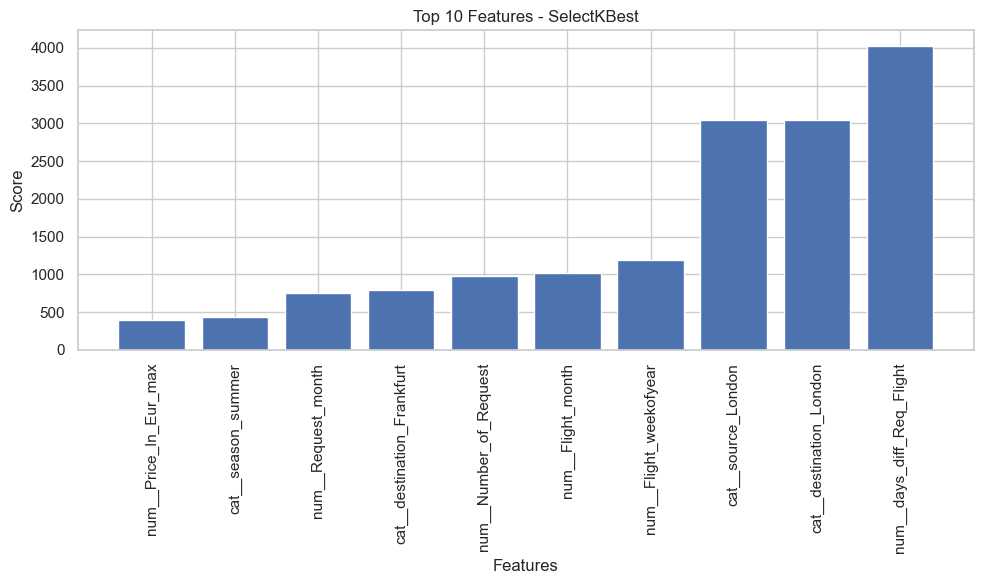

In [104]:

# SelectKBest-Transformer mit der gewünschten Score-Funktion erstellen
kbest = SelectKBest(score_func=f_classif, k=10)  # Wähle die 10 besten Features

# Transformer auf die Daten anwenden 
Xtrain_selected = kbest.fit_transform(Xtrain_transformed.toarray(), y_train)

# Die ausgewählten Feature-Indizes erhalten
feature_indices = kbest.get_support(indices=True)

# Die Namen der ausgewählten Features erhalten
selected_features = frame.columns[feature_indices]

# Die ausgewählten Features anzeigen
#print(f"Die 10 besten Merkmale zur Vorhersage von Buy nach SelectKBest-Transformer sind: {[i for i in list(selected_features)]}")

#Score
feature_scores = kbest.scores_

# Erstelle ein Array mit den Rängen der Features (absteigend sortiert)
top_10_features = np.argsort(feature_scores)[-10:]

# Plotte die Scores der k besten Features
plt.figure(figsize=(10, 6))
plt.bar(range(10), feature_scores[top_10_features])
plt.xticks(range(10), np.array(transformed_feature_names)[top_10_features], rotation=90)
plt.xlabel('Features')
plt.ylabel('Score')
plt.title(f'Top 10 Features - SelectKBest')
plt.tight_layout()
plt.show()







- #### Mit LassoCV

In [107]:

# Lasso-Regression-Modell mit Kreuzvalidierung erstellen
lasso_cv = LassoCV(cv=10,random_state=529)  # cv ist die Anzahl der Folds für die Kreuzvalidierung

# Führe die Feature Selection durch
lasso_cv.fit(Xtrain_transformed.toarray(), y_train)


# Rufe die Koeffizienten der ausgewählten Features ab
feature_coef = lasso_cv.coef_

# Rufe die ausgewählten Feature-Indizes ab
selected_feature_indices = np.nonzero(feature_coef)[0]

# Rufe die ausgewählten Feature-Namen ab
selected_feature_names = frame.columns[selected_feature_indices]

# Drucke die ausgewählten Feature-Namen
print("Die ausgewählten Features sind:")
for feature_name in selected_feature_names:
    print(feature_name)



Die ausgewählten Features sind:
num__Price_In_Eur
num__Price_In_Eur_min
num__Price_In_Eur_mean
num__Number_of_Request
num__days_diff_Req_Flight
num__Request_Dayofweek
num__Request_month
num__Flight_Dayofweek
num__Flight_month
num__Flight_weekofyear
cat__season_summer
cat__departure_time_Evening
cat__departure_time_Morning
cat__Request_time_Late Night
cat__source_Frankfurt
cat__source_London
cat__destination_Frankfurt
cat__destination_London


## Anpassung des Models

In [86]:
# Model trainieren
clf = lgb.LGBMClassifier()
clf.fit(frame[selected_feature_names], y_train)

# Vorhersage von Buy mit Traningsdaten
pred = clf.predict(frame[selected_feature_names])
pred_prob = clf.predict_proba(frame[selected_feature_names])[:,1]

#Genauigkeit messen
acc = accuracy_score(y_train,pred)
print(f'Trainingsdaten-Genauigkeit: {acc}')

Trainingsdaten-Genauigkeit: 0.8943165992439817


## Vorhersage von Validierungsdaten

In [87]:
pred = clf.predict(frame_val[selected_feature_names])
pred_prob = clf.predict_proba(frame_val[selected_feature_names])[:,1]
acc = accuracy_score(y_val,pred)
print(f'Validierungsdaten-Genauigkeit: {acc}')


Validierungsdaten-Genauigkeit: 0.8717948717948718


# Versuche

In [ ]:
 #Feature Selection (Zielvariable= Min_future_preis)
#### Mit Selectkbest 

In [ ]:

# SelectKBest-Transformer mit der gewünschten Score-Funktion erstellen
#kbest_clf = SelectKBest(score_func=f_classif, k=10)  # Wähle die 10 besten Features

# Transformer auf die Daten anwenden 
#X_selected = kbest_clf.fit_transform(X_transformed, y_Buy)

# Die ausgewählten Feature-Indizes erhalten
#feature_indices = kbest_clf.get_support(indices=True)

# Die Namen der ausgewählten Features erhalten
#selected_features = transformed_feature_names[feature_indices]

# Die ausgewählten Features anzeigen
#print(f"Die 10 besten Merkmale zur Vorhersage von min_future_price nach SelectKBest-Transformer sind: {[i for i in list(selected_features)]}")



- #### Mit LassoCV

In [ ]:
# Lasso-Regression-Modell mit Kreuzvalidierung erstellen
#lasso_cv = LassoCV(cv=10)  # cv ist die Anzahl der Folds für die Kreuzvalidierung

# Modell auf die Daten anpassen
#lasso_cv.fit(X_transformed, y_min_Price)

# Wichtige Features identifizieren
#important_features = lasso_cv.coef_ != 0

# Ergebnisse anzeigen
#selected_feature_names = [transformed_feature_names[i] for i in range(len(transformed_feature_names)) if important_features[i]]
#print(f"Wichtige Merkmale: \n{[i for i in selected_feature_names]}")

In [ ]:
#import plotly.express as px
#import plotly.graph_objects as go

# Gruppieren und aggregieren der Daten
#grouped_data = flug_df.groupby(['Flight_Date', 'route_abb']).agg(anzahl_flug_per_day=('flight_unique_id', 'nunique'), mean_price_per_flight_date=('Price_In_Eur', 'mean')).reset_index()

# Plot erstellen
#fig = px.bar(grouped_data, x='Flight_Date', y='anzahl_flug_per_day', color='route_abb')



# Layout anpassen
#fig.update_layout(
#    xaxis_title='Flight Date',
 #   yaxis_title='Anzahl Flüge pro Tag',
  #  title='Anzahl Flüge pro Tag und Route'
#)

# Diagramm anzeigen
#fig.show()
